# XGBoost
Como se planteo en la preentrega de este proyecto, la idea es conocer el algoritmo `XGBClassifier` pues creemos que tiene un potencial enorme en los entornos bancarios. Pero, el detalle en finanzas (interés propio en esta área) es que los casos son muy desbalanceados, por tanto consideramos que era un hambiente desafiante y educativo arriesgarnos a un tema así, por ello todo el proyecto se centra en presentar un modelo adecuado al curso. 

## Modelo simple
Adaptamos el modelo visto en clase con las ideas del eda que hicimos. 

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier


df_xg = pd.read_csv("https://raw.githubusercontent.com/dt-sc-Josue-Diaz/Proyecto-DS-II/refs/heads/main/05_models_evaluation/data_para_entrenamiento.csv")
df_xg = df_xg.drop(columns=['Unnamed: 0'])

X = df_xg.drop(columns=['moroso'])
y = df_xg['moroso']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgboost = XGBClassifier(eval_metric='logloss')
xgboost.fit(X_train, y_train)
y_pred_train_xgb = xgboost.predict(X_train)
y_pred_test_xgb = xgboost.predict(X_test)

print("Training")
print(classification_report(y_train, y_pred_train_xgb))
print("---------------------------------------------------------")
print("Test")
print(classification_report(y_test, y_pred_test_xgb))

Training
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     95394
           1       0.82      0.31      0.45      6859

    accuracy                           0.95    102253
   macro avg       0.89      0.65      0.71    102253
weighted avg       0.94      0.95      0.94    102253

---------------------------------------------------------
Test
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     40835
           1       0.56      0.20      0.29      2988

    accuracy                           0.93     43823
   macro avg       0.75      0.59      0.63     43823
weighted avg       0.92      0.93      0.92     43823



Los resultados en test no son alentadores. Son mejor que el azar, por ello vamos a optimizar este modelo a diferencia de los otros. 

## Optimizacion: 
A primera instancia, nuestros primeros modelos eran batante malos, al principio los largos entrenamientos nos hicieron ver que no podiamos hacer todos los parámetros de nuestras sospechas, por lo que nos llevo a incursionar en el experimento de cambiar el tamaño de las muestras de la clase 0 y aumentarlas gradualmente, la idea es más bien robada de la [ley de los grandes numeros](https://es.wikipedia.org/wiki/Ley_de_los_grandes_n%C3%BAmeros), si tuvieramos la misma cantidad de elementos en la clase 0 y 1 entonces un modelo podría tener mejor rendimiento, con el azar debería ser una proba de 50 a 50, pero el rendimiento era mejor sin emgargo también pasaba que estos modelos al evaluarlos por un tamaño mas grande del set, perdian notablemente rendimiento, solo era bueno tanto el tamaño no fuera muy grande, o bien un tamaño cercano al cual fue entrenado. Esto tenia sentido pues los hiperparámetros del `param_grid` no pueden ser tan distintos, la continuidad (en el sentido del matemático) de los modelos, debería indicarnos que los mejores modelos deben estar cercanos. Entonces obtuvimos hiperparámtros mas en concretos. 

Además con este [video](https://youtu.be/GR-OW5asKlk?si=0pVUBpa5_SP-Vzui) nos llevo al modelo presentado con la curva ROC. Para una mejor explicación, el eda realizado no fue adecuado para el manejo de los outliers y Nas. Por fines del modelo, entonces hacemos estos cambios, en las gráficas no se nota una mejora en la representaciòn, por lo que no vemos necesario generar mas archivos gráficos y para el entrenamiento pues solo necesitamos tres lineas de código. 

Dado el tamaño del data set y del balance, es muy probable que al momento de hacer los sets, el sesgo de como quedan las clases no sea representativa. Con `StratifiedShuffleSplit` consideramos un muestreo en ambas clases, 0 y 1, de 30 porcieto para test. Más adelante puede comproabarse que;

In [ ]:
X_train.shape[0]/y.shape[0] , y_train.shape[0]/y.shape[0]

In [ ]:
X_test.shape[0]/y.shape[0] , y_test.shape[0]/y.shape[0]


O sea, por clase garantizamos que de y == 0, se haga una proporcion de 30% y 60% y lo mismo para y==1. Así no perdemos representatividad de y==1. Que puede perderse por el tamaño de la clase. Ahora hacemos un cambio de escala que nos funcionó. 


Como mencionamos antes, en los anexos se puede encontar como fuimos encontrando este grid. 
En `grid_search`notemos que; `cv=3` es la validacion cruzada a 3 folds. O sea que se divide en 3 partes el conjunto de entrenamiento para que el modelo evalue 3 veces y 3 veces hace la validacion. Como mecionamos en la presentacion de la preentrega, nos dimos a probar las metricas. El ROC es una curva que muestra la relación entre dos métricas; 

- True Positive Rate (TPR) o Recall (sensibilidad).
- False Positive Rate (FPR): Proporción de negativos reales mal clasificados como positivos.

Eje X: False Positive Rate (FPR).
Eje Y: True Positive Rate (TPR).

Un ejemplo grafico de esto puede encontrarse en [Curva ROC](https://youtu.be/fsgDD0pNkZ0?si=KyYXyMSoemTY70je). La curva AUC (Area Under the Curve)  es el área bajo la curva ROC y representa una métrica resumida para evaluar la capacidad de un modelo de distinguir entre las clases.

- Valor cercano a 1: Excelente discriminación.
- Valor de 0.5: El modelo no tiene capacidad de discriminar mejor que un modelo aleatorio.

`verbose=1` es para seguir el proceso. 

Lo que corresponde ahora es el entrenamiento. El cual consideramos bastante bueno por el tiempo de ejecución con el resultado que se obtuvo. 

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\ldiazalv\Anaconda3\envs\coder\lib\site-packages\xgboost\core.py:158: UserWarning: [02:08:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores parámetros: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 250, 'scale_pos_weight': 1, 'subsample': 0.7}
ROC-AUC (Entrenamiento): 0.89
ROC-AUC (Prueba): 0.87
Métricas de clasificación - Entrenamiento
              precision    recall  f1-score   support

           0       0.80      0.83      0.81      7018
           1       0.82      0.79      0.80      7018

    accuracy                           0.81     14036
   macro avg       0.81      0.81      0.81     14036
weighted avg       0.81      0.81      0.81     14036

---------------------------------------------------------
Métricas de clasificación - Prueba
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      3008
           1       0.81      0.77      0.79      3008

    accuracy                           0.80      6016
   macro avg       0.80      0.80      0.80      6016
weighted avg       0.80      0.80      0.80      6016

-----------

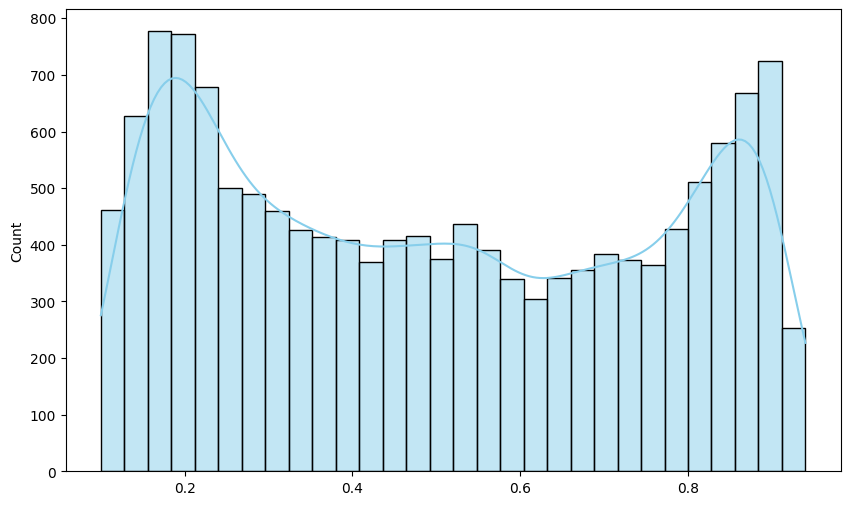

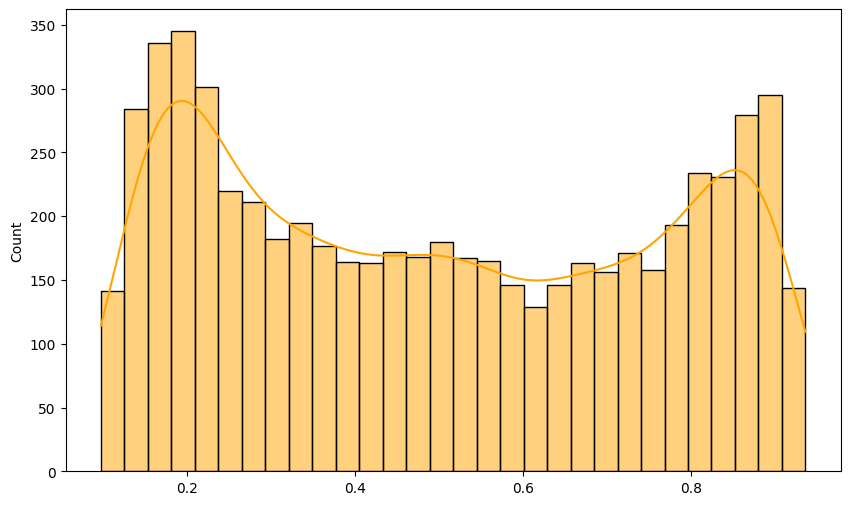

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_xg_op = pd.read_csv('https://raw.githubusercontent.com/dt-sc-Josue-Diaz/preentrega/refs/heads/main/data_credit_training.csv')
df_xg_op.columns

df_xg_op['MonthlyIncome'] = df_xg_op['MonthlyIncome'].fillna(df_xg_op['MonthlyIncome'].median())
df_xg_op['NumberOfDependents'] = df_xg_op['NumberOfDependents'].fillna(0)  # Si 0 tiene sentido
df_xg_op['DebtRatio'] = df_xg_op['DebtRatio'].clip(upper=1)

X_op = df_xg_op.drop(columns=['SeriousDlqin2yrs'])
y_op = df_xg_op['SeriousDlqin2yrs']

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from joblib import dump
import numpy as np

# Undersampling de la clase mayoritaria
undersampler = RandomUnderSampler(random_state=42)
X_op, y_op = undersampler.fit_resample(X_op, y_op)

# Dividir los datos en entrenamiento y prueba
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
for train_index, test_index in sss.split(X_op, y_op):
    X_train, X_test = X_op.iloc[train_index], X_op.iloc[test_index]
    y_train, y_test = y_op.iloc[train_index], y_op.iloc[test_index]

# Escalar los datos; recomendacion de chatgp
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calcular el peso para balancear las clases
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Parámetros para GridSearchCV
param_grid = {
    'n_estimators': [250],
    'max_depth': [5,7],
    'learning_rate': [0.01, 0.001],
    'subsample': [0.7, 0.5],
    'colsample_bytree': [0.3, 0.5],
    'scale_pos_weight': [1, scale_pos_weight]  # Ajuste de pesos de clase
}

# GridSearchCV con XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Evaluacion en test y training
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

# Obtener las probabilidades para ROC-AUC
y_pred_train_proba = best_model.predict_proba(X_train_scaled)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Evaluar en conjunto de entrenamiento y prueba
roc_auc_train = roc_auc_score(y_train, y_pred_train_proba)
roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

# Agragado despues por resultados con chatgpt
print(f"ROC-AUC (Entrenamiento): {roc_auc_train:.2f}")
print(f"ROC-AUC (Prueba): {roc_auc_test:.2f}")

print("Métricas de clasificación - Entrenamiento")
print(classification_report(y_train, y_pred_train))
print("---------------------------------------------------------")

print("Métricas de clasificación - Prueba")
print(classification_report(y_test, y_pred_test))
print("---------------------------------------------------------")

# Retornar el modelo y métricas; tomado de chatgpt
modelo, metricas  = best_model, {
    'roc_auc_train': roc_auc_train,
    'roc_auc_test': roc_auc_test,
    'classification_report_train': classification_report(y_train, y_pred_train, output_dict=True),
    'classification_report_test': classification_report(y_test, y_pred_test, output_dict=True)
}

# Visualizar la distribucion 
plt.figure(figsize=(10,6))
sns.histplot(y_pred_train_proba, bins=30, kde=True, color='skyblue')
plt.show()


plt.figure(figsize=(10,6))
sns.histplot(y_pred_test_proba, bins=30, kde=True, color='orange')
plt.show()

De acuerdo al texto previo al modelo. 
- ROC-AUC; son valores cercanos a 1, no tanto para ser un excelente rendimiento pero muy bueno a nivel data set. Por lo que el modelo está logrando distinguir entre clases. 
- Presicion y Recall estan muy cercanos entre si y cercanos a uno, por lo cual la cantidad de falsos negativos y positivos está siendo consistente en cada clase. Aún así no son las mejores, pues en proporción al data set son cantidades muy grandes. 
- El valor de f-1 muestra un equilibrio entre las metricas anteriores. Lo cual permite concluir que el modelo está distinguiendo entre clases. 
- Por estas metricas no parace que haya un sobre ajuste, pero consideramos que es un resultado entre el tiempo y los fines de esta entrega. Seguramente hya mas tácnicas mas complejas para usarse. 


## Con chatgpt
El modelo anterior es uno mas fino que el conseguido, mas eficiente, un tiempo de corrida eficiente. Consideramos un modelo que el primero. Luego, pensamos que pasaria si le pedimos a chatgpt que lo mejorara. Lo que nos dio. 

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


c:\Users\ldiazalv\Anaconda3\envs\coder\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\ldiazalv\Anaconda3\envs\coder\lib\site-packages\xgboost\core.py:158: UserWarning: [02:03:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores parámetros: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': 1.0, 'subsample': 0.7}
Modelo guardado como xgboost_best_model.joblib
ROC-AUC (Entrenamiento): 0.89
ROC-AUC (Prueba): 0.87
Métricas de clasificación - Entrenamiento
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      7018
           1       0.82      0.79      0.80      7018

    accuracy                           0.81     14036
   macro avg       0.81      0.81      0.81     14036
weighted avg       0.81      0.81      0.81     14036

---------------------------------------------------------
Métricas de clasificación - Prueba
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      3008
           1       0.80      0.78      0.79      3008

    accuracy                           0.79      6016
   macro avg       0.79      0.79   

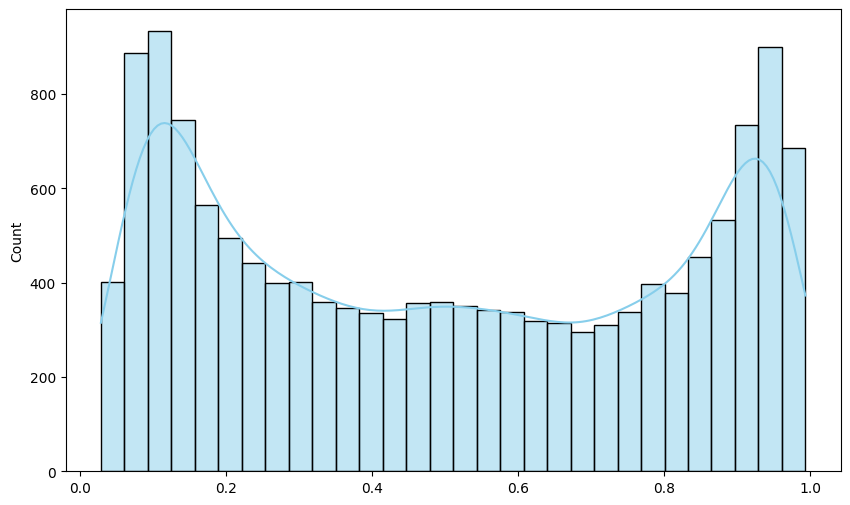

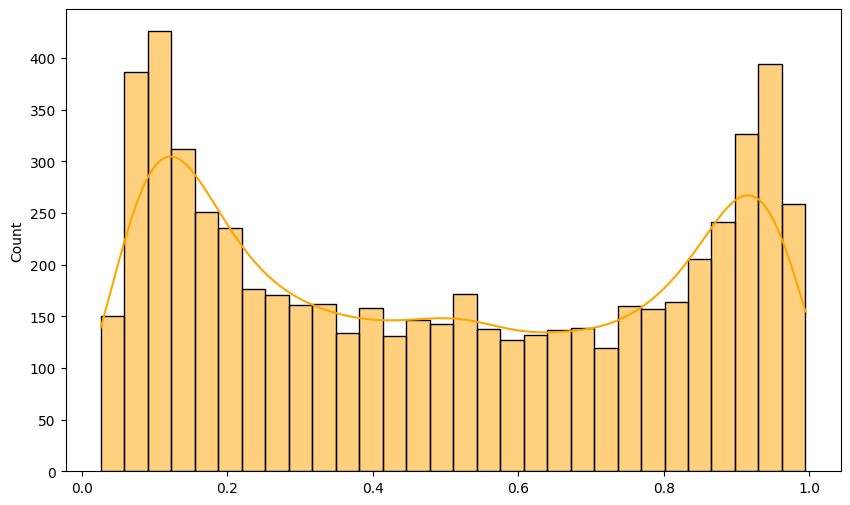

In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from joblib import dump
import numpy as np

# Dividir los datos en entrenamiento y prueba
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
for train_index, test_index in sss.split(X_op, y_op):
    X_train, X_test = X_op.iloc[train_index], X_op.iloc[test_index]
    y_train, y_test = y_op.iloc[train_index], y_op.iloc[test_index]

# Aplicar SMOTE para balancear clases
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Calcular el peso para balancear las clases
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# Parámetros para GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.5, 0.7],
    'scale_pos_weight': [1.0, scale_pos_weight],
    'gamma': [0, 0.1],  # Regularización adicional para evitar el sobreajuste
    'min_child_weight': [1, 3]  # Controla la complejidad del modelo
}

# GridSearchCV con XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='aucpr')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train_resampled)

# Mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Guardar modelo
model_filename = 'xgboost_best_model.joblib'
dump(best_model, model_filename)
print(f"Modelo guardado como {model_filename}")

# Predicciones y evaluación
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

# Obtener las probabilidades para ROC-AUC
y_pred_train_proba = best_model.predict_proba(X_train_scaled)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Evaluar en conjunto de entrenamiento y prueba
roc_auc_train = roc_auc_score(y_train_resampled, y_pred_train_proba)
roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

print(f"ROC-AUC (Entrenamiento): {roc_auc_train:.2f}")
print(f"ROC-AUC (Prueba): {roc_auc_test:.2f}")

print("Métricas de clasificación - Entrenamiento")
print(classification_report(y_train_resampled, y_pred_train))
print("---------------------------------------------------------")

print("Métricas de clasificación - Prueba")
print(classification_report(y_test, y_pred_test))
print("---------------------------------------------------------")

# Retornar el modelo y métricas
modelo, metricas  = best_model, {
    'roc_auc_train': roc_auc_train,
    'roc_auc_test': roc_auc_test,
    'classification_report_train': classification_report(y_train_resampled, y_pred_train, output_dict=True),
    'classification_report_test': classification_report(y_test, y_pred_test, output_dict=True)
}


# Visualizar la distribucion 
plt.figure(figsize=(10,6))
sns.histplot(y_pred_train_proba, bins=30, kde=True, color='skyblue')
plt.show()


plt.figure(figsize=(10,6))
sns.histplot(y_pred_test_proba, bins=30, kde=True, color='orange')
plt.show()

# Apendice de intentos fallidos.
En esta sección solo es interesante ver que el comportamiento de los modelos mientras crece la clase 0. Esto no deberia considerarse parte de la entrega, pero el proyecto fue realizado en mas de una computadora, en fines pràcticos para no perder estos regsistros, considero mas condierar esto como un anexo informativo que mas parte de la entrega. 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


X = df.drop(columns=['SeriousDlqin2yrs'])  # Características
y = df['SeriousDlqin2yrs']  # Variable objetivo


# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Escalado de los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir modelo base y parámetros para GridSearch
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [200,300],
    'max_depth': [3,5,7],
    'learning_rate': [0.1, 0.01,.001],
    'subsample': [0.4, .5, .6],
    'colsample_bytree': [0.6, 0.8],
    'scale_pos_weight': [1, len(y[y == 0]) / len(y[y == 1])]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Ajustar modelo
grid_search.fit(X_train, y_train)

# Extraer el mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Predicciones en entrenamiento y prueba
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Probabilidades para ROC-AUC
y_pred_train_proba = best_model.predict_proba(X_train)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]

# Reportes de clasificación
print("Training")
print(classification_report(y_train, y_pred_train))
print("ROC-AUC Score (Train):", roc_auc_score(y_train, y_pred_train_proba))
print("---------------------------------------------------------")
print("Test")
print(classification_report(y_test, y_pred_test))
print("ROC-AUC Score (Test):", roc_auc_score(y_test, y_pred_test_proba))


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Oversampling con SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escalado de los datos
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Ajustar el peso de la clase minoritaria
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# Definir modelo base y parámetros para GridSearch
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [250, 350],
    'max_depth': [5, 6],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.7, 0.5],
    'colsample_bytree': [0.7, 0.8],
    'scale_pos_weight': [1, scale_pos_weight]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Ajustar modelo
grid_search.fit(X_train_resampled, y_train_resampled)

# Extraer el mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Predicciones en entrenamiento y prueba
y_pred_train = best_model.predict(X_train_resampled)
y_pred_test = best_model.predict(X_test)

# Probabilidades para ROC-AUC
y_pred_train_proba = best_model.predict_proba(X_train_resampled)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]

# Reportes de clasificación
print("Training")
print(classification_report(y_train_resampled, y_pred_train))
print("ROC-AUC Score (Train):", roc_auc_score(y_train_resampled, y_pred_train_proba))
print("---------------------------------------------------------")
print("Test")
print(classification_report(y_test, y_pred_test))
print("ROC-AUC Score (Test):", roc_auc_score(y_test, y_pred_test_proba))


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Oversampling con SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escalado de los datos
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Ajustar el peso de la clase minoritaria
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# Definir modelo base y parámetros para GridSearch
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# Ajuste de parámetros para optimizar F1-Score
param_grid = {
    'n_estimators': [250, 350],
    'max_depth': [5, 6],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.7, 0.5],
    'colsample_bytree': [0.7, 0.8],
    'scale_pos_weight': [1, scale_pos_weight]
}

# Configurar GridSearchCV para F1-Score
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',  # Cambiado a f1-score
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Ajustar modelo
grid_search.fit(X_train_resampled, y_train_resampled)

# Extraer el mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Predicciones en entrenamiento y prueba
y_pred_train = best_model.predict(X_train_resampled)
y_pred_test = best_model.predict(X_test)

# Probabilidades para F1-Score
y_pred_train_proba = best_model.predict_proba(X_train_resampled)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]

# Reportes de clasificación
print("Training")
print(classification_report(y_train_resampled, y_pred_train))
print("F1-Score (Train):", f1_score(y_train_resampled, y_pred_train))
print("---------------------------------------------------------")
print("Test")
print(classification_report(y_test, y_pred_test))
print("F1-Score (Test):", f1_score(y_test, y_pred_test))


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Oversampling con SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escalado de los datos
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Ajustar el peso de la clase minoritaria
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# Definir modelo base y parámetros para GridSearch
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# Ajuste de parámetros para optimizar F1-Score
param_grid = {
    'n_estimators': [450, 350],
    'max_depth': [5, 3],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.6, 0.5],
    'colsample_bytree': [0.7, 0.8],
    'scale_pos_weight': [scale_pos_weight]
}

# Configurar GridSearchCV para F1-Score
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',  # Cambiado a f1-score
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Ajustar modelo
grid_search.fit(X_train_resampled, y_train_resampled)

# Extraer el mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Predicciones en entrenamiento y prueba
y_pred_train = best_model.predict(X_train_resampled)
y_pred_test = best_model.predict(X_test)

# Probabilidades para F1-Score
y_pred_train_proba = best_model.predict_proba(X_train_resampled)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]

# Ajustar el umbral de clasificación para mejorar el F1-Score
threshold = 0.4  # Puedes probar con otros valores de umbral
y_pred_test_adjusted = (y_pred_test_proba >= threshold).astype(int)

# Reportes de clasificación
print("Training")
print(classification_report(y_train_resampled, y_pred_train))
print("F1-Score (Train):", f1_score(y_train_resampled, y_pred_train))
print("---------------------------------------------------------")
print("Test")
print(classification_report(y_test, y_pred_test_adjusted))  # Usando el umbral ajustado
print("F1-Score (Test):", f1_score(y_test, y_pred_test_adjusted))  # F1 ajustado en test


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Oversampling con SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escalado de los datos
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Ajustar el peso de la clase minoritaria
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# Definir modelo base y parámetros para GridSearch
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# Ajuste de parámetros para optimizar F1-Score
param_grid = {
    'n_estimators': [250, 350, 450],
    'max_depth': [5, 6],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.7, 0.8],
    'scale_pos_weight': [1, scale_pos_weight]
}

# Configurar GridSearchCV para F1-Score
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',  # Cambiado a f1-score
    cv=5,  # Aumentar a 5 folds para mejor robustez
    verbose=1,
    n_jobs=-1
)

# Ajustar modelo
grid_search.fit(X_train_resampled, y_train_resampled)

# Extraer el mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Predicciones en entrenamiento y prueba
y_pred_train = best_model.predict(X_train_resampled)
y_pred_test = best_model.predict(X_test)

# Probabilidades para F1-Score
y_pred_train_proba = best_model.predict_proba(X_train_resampled)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]

# Ajustar el umbral de clasificación para mejorar el F1-Score
threshold = 0.4  # Probar con un umbral de 0.4
y_pred_test_adjusted = (y_pred_test_proba >= threshold).astype(int)

# Reportes de clasificación
print("Training")
print(classification_report(y_train_resampled, y_pred_train))
print("F1-Score (Train):", f1_score(y_train_resampled, y_pred_train))
print("---------------------------------------------------------")
print("Test")
print(classification_report(y_test, y_pred_test_adjusted))  # Usando el umbral ajustado
print("F1-Score (Test):", f1_score(y_test, y_pred_test_adjusted))  # F1 ajustado en test


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Oversampling con SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escalado de los datos
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Ajustar el peso de la clase minoritaria
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# Definir modelo base y parámetros para GridSearch
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# Ajuste de parámetros para optimizar F1-Score
param_grid = {
    'n_estimators': [250, 350, 450],
    'max_depth': [5, 6],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.7, 0.8],
    'scale_pos_weight': [1, scale_pos_weight, 10, 20]
}

# Configurar GridSearchCV para F1-Score
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',  # Cambiado a f1-score
    cv=5,  # Aumentar a 5 folds para mejor robustez
    verbose=1,
    n_jobs=-1
)

# Ajustar modelo
grid_search.fit(X_train_resampled, y_train_resampled)

# Extraer el mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Predicciones en entrenamiento y prueba
y_pred_train = best_model.predict(X_train_resampled)
y_pred_test = best_model.predict(X_test)

# Probabilidades para F1-Score y ROC-AUC
y_pred_train_proba = best_model.predict_proba(X_train_resampled)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]

# Ajustar el umbral de clasificación para mejorar el F1-Score
threshold = 0.3  # Probar con un umbral más bajo
y_pred_test_adjusted = (y_pred_test_proba >= threshold).astype(int)

# Reportes de clasificación
print("Training")
print(classification_report(y_train_resampled, y_pred_train))
print("F1-Score (Train):", f1_score(y_train_resampled, y_pred_train))
print("---------------------------------------------------------")
print("Test")
print(classification_report(y_test, y_pred_test_adjusted))  # Usando el umbral ajustado
print("F1-Score (Test):", f1_score(y_test, y_pred_test_adjusted))  # F1 ajustado en test
print("---------------------------------------------------------")
# AUC-ROC para evaluar desempeño global
print(f"ROC-AUC (Test): {roc_auc_score(y_test, y_pred_test_proba)}")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Oversampling con SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escalado de los datos
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Ajustar el peso de la clase minoritaria
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# Definir modelo base y parámetros para GridSearch
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# Ajuste de parámetros para optimizar F1-Score
param_grid = {
    'n_estimators': [250, 350, 450],
    'max_depth': [5, 6],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.7, 0.8],
    'scale_pos_weight': [1, scale_pos_weight, 10, 20]
}

# Configurar GridSearchCV para F1-Score
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',  # Cambiado a f1-score
    cv=5,  # Aumentar a 5 folds para mejor robustez
    verbose=1,
    n_jobs=-1
)

# Ajustar modelo
grid_search.fit(X_train_resampled, y_train_resampled)

# Extraer el mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Predicciones en entrenamiento y prueba
y_pred_train = best_model.predict(X_train_resampled)
y_pred_test = best_model.predict(X_test)

# Probabilidades para F1-Score y ROC-AUC
y_pred_train_proba = best_model.predict_proba(X_train_resampled)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]

# Ajustar el umbral de clasificación para mejorar el F1-Score
threshold = 0.3  # Probar con un umbral más bajo
y_pred_test_adjusted = (y_pred_test_proba >= threshold).astype(int)

# Reportes de clasificación
print("Training")
print(classification_report(y_train_resampled, y_pred_train))
print("F1-Score (Train):", f1_score(y_train_resampled, y_pred_train))
print("---------------------------------------------------------")
print("Test")
print(classification_report(y_test, y_pred_test_adjusted))  # Usando el umbral ajustado
print("F1-Score (Test):", f1_score(y_test, y_pred_test_adjusted))  # F1 ajustado en test
print("---------------------------------------------------------")
# AUC-ROC para evaluar desempeño global
print(f"ROC-AUC (Test): {roc_auc_score(y_test, y_pred_test_proba)}")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Oversampling con SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escalado de los datos
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Ajustar el peso de la clase minoritaria
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# Definir modelo base y parámetros para GridSearch
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# Ajuste de parámetros para optimizar F1-Score
param_grid = {
    'n_estimators': [250, 350, 450],
    'max_depth': [5, 6],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.7, 0.8],
    'scale_pos_weight': [1, scale_pos_weight, 10, 20]
}

# Configurar GridSearchCV para F1-Score
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',  # Cambiado a f1-score
    cv=5,  # Aumentar a 5 folds para mejor robustez
    verbose=1,
    n_jobs=-1
)

# Ajustar modelo
grid_search.fit(X_train_resampled, y_train_resampled)

# Extraer el mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Predicciones en entrenamiento y prueba
y_pred_train = best_model.predict(X_train_resampled)
y_pred_test = best_model.predict(X_test)

# Probabilidades para F1-Score y ROC-AUC
y_pred_train_proba = best_model.predict_proba(X_train_resampled)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]

# Ajustar el umbral de clasificación para mejorar el F1-Score
threshold = 0.3  # Probar con un umbral más bajo
y_pred_test_adjusted = (y_pred_test_proba >= threshold).astype(int)

# Reportes de clasificación
print("Training")
print(classification_report(y_train_resampled, y_pred_train))
print("F1-Score (Train):", f1_score(y_train_resampled, y_pred_train))
print("---------------------------------------------------------")
print("Test")
print(classification_report(y_test, y_pred_test_adjusted))  # Usando el umbral ajustado
print("F1-Score (Test):", f1_score(y_test, y_pred_test_adjusted))  # F1 ajustado en test
print("---------------------------------------------------------")
# AUC-ROC para evaluar desempeño global
print(f"ROC-AUC (Test): {roc_auc_score(y_test, y_pred_test_proba)}")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Definir las variables predictoras y la variable objetivo
X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

# Dividir los datos en conjunto de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# Aplicar SMOTE para balancear el conjunto de entrenamiento (oversampling de la clase minoritaria)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escalado de las características utilizando StandardScaler
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Calcular el peso de la clase minoritaria para ajustar la ponderación en el modelo
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# Definir el modelo base (XGBoost) y los parámetros para el ajuste mediante GridSearchCV
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# Definir el rango de parámetros para GridSearch
param_grid = {
    'n_estimators': [350],  # Número de árboles en el modelo
    'max_depth': [11],  # Profundidad máxima del árbol
    'learning_rate': [0.1,.01],  # Tasa de aprendizaje
    'subsample': [0.4,0.5,0.6],  # Porcentaje de muestras utilizadas para entrenar cada árbol
    'colsample_bytree': [0.7, 0.6,0.5],  # Proporción de características seleccionadas por árbol
    'scale_pos_weight': [scale_pos_weight]  # Ajuste para balancear las clases
}

# Configurar GridSearchCV para optimizar según F1-Score
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',  # Optimizamos por el F1-Score
    cv=5,  # Usar validación cruzada con 5 pliegues
    verbose=1,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ajustar el modelo con los mejores parámetros encontrados
grid_search.fit(X_train_resampled, y_train_resampled)

# Obtener el mejor modelo con los mejores parámetros
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Realizar predicciones en los conjuntos de entrenamiento y prueba
y_pred_train = best_model.predict(X_train_resampled)
y_pred_test = best_model.predict(X_test)

# Obtener las probabilidades para calcular F1-Score y ROC-AUC
y_pred_train_proba = best_model.predict_proba(X_train_resampled)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]

# Ajustar el umbral de clasificación para mejorar el F1-Score (ajustamos el umbral)
thresholds = [0.15, 0.25, 0.35,0.45] # Umbral ajustado para mejorar la clasificación de la clase minoritaria
for threshold in thresholds:
    y_pred_test_adjusted = (y_pred_test_proba >= threshold).astype(int)
    # Reportes de clasificación para el conjunto de entrenamiento
    print("Training")
    print(classification_report(y_train_resampled, y_pred_train))
    print("F1-Score (Train):", f1_score(y_train_resampled, y_pred_train))
    print("---------------------------------------------------------")

    # Reportes de clasificación para el conjunto de prueba
    print("Test")
    print(classification_report(y_test, y_pred_test_adjusted))  # Usar el umbral ajustado
    print("F1-Score (Test):", f1_score(y_test, y_pred_test_adjusted))  # F1 ajustado en test
    print("---------------------------------------------------------")

    # AUC-ROC para evaluar el desempeño global del modelo
    print(f"ROC-AUC (Test): {roc_auc_score(y_test, y_pred_test_proba)}")

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE


df = pd.read_csv("https://raw.githubusercontent.com/dt-sc-Josue-Diaz/Proyecto-DS-II/refs/heads/main/05_models_evaluation/data_para_entrenamiento.csv")
df = df.drop('Unnamed: 0',axis = 'columns')


def entrenar_1(df):

    X = df.drop(columns=['moroso'])
    y = df['moroso']

    param_grid_1 = {
        'n_estimators': [125, 150, 175, 200],
        'max_depth': [5, 7, 9],
        'learning_rate': [0.005],
        'subsample': [0.6, 0.7, 0.8, 1.0],  # Ajuste de filas por árbol
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7],  # Ajuste de columnas por árbol
        'min_child_weight': [1, 2, 3]
    }

    xgboost = XGBClassifier(subsample=0.5, colsample_bytree=0.5, eval_metric='logloss')

    grid_search = GridSearchCV(estimator=xgboost, 
                            param_grid = param_grid_1, 
                            scoring="precision", 
                            cv=5)


    grid_search.fit(X_train,y_train)

    best_model = grid_search.best_estimator_
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)


    print("Training")
    print(classification_report(y_train, y_pred_train))
    print("---------------------------------------------------------")
    print("Test")
    print(classification_report(y_test, y_pred_test))

In [ ]:
xgboost_1 = (eval_metric='logloss')

param_grid_1 = {
        'n_estimators': [125, 150, 175, 200],
        'max_depth': [5, 7, 9],
        'learning_rate': [0.005],
        'subsample': [0.6, 0.7, 0.8, 1.0],  # Ajuste de filas por árbol
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7],  # Ajuste de columnas por árbol
        'min_child_weight': [1, 2, 3]
    }

# GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(
    estimator=xgboost_1, 
    param_grid=param_grid_1, 
    scoring="precision",  # Métrica de precisión
    cv=5,                 # Validación cruzada
    n_jobs=-1             # Uso de todos los núcleos
)

# Entrenar el modelo
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Realizar predicciones
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Resultados
print("Training Metrics")
print(classification_report(y_train, y_pred_train))
print("---------------------------------------------------------")
print("Test Metrics")
print(classification_report(y_test, y_pred_test))

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Calcular scale_pos_weight para ajustar el desbalance
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Configurar el modelo con scale_pos_weight
xgboost_1 = XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight)

# Hiperparámetros para la búsqueda
param_grid_1 = {
    'n_estimators': [125, 150, 175, 200],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.005],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7],
    'min_child_weight': [1, 2, 3]
}

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(
    estimator=xgboost_1,
    param_grid=param_grid_1,
    scoring="f1",  # Métrica de evaluación balanceada
    cv=cv,
    n_jobs=-1
)

# Entrenar el modelo
grid_search.fit(X_train_resampled, y_train_resampled)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Realizar predicciones
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Resultados
print("Training Metrics")
print(classification_report(y_train, y_pred_train))
print("---------------------------------------------------------")
print("Test Metrics")
print(classification_report(y_test, y_pred_test))

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedShuffleSplit



dividir_clase = StratifiedShuffleSplit(n_splits=1, test_size=.3, random_state=45)

for ent_index, target_index in dividir_clase.split(df,df['moroso']):
    set_train = df.loc[ent_index]
    set_test = df.loc[target_index]




In [ ]:
set_train['moroso'].value_counts()/df.shape[0]

In [ ]:
set_test['moroso'].value_counts()/df.shape[0]

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedShuffleSplit



def entrenar_por_tam(n): 

    X_train = 
    y_train =
    

    
    # Calcular scale_pos_weight para ajustar el desbalance
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    # Configurar el modelo con scale_pos_weight
    xgboost_1 = XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight)

    # Hiperparámetros para la búsqueda
    param_grid_1 = {
        'n_estimators': [125, 150, 175, 200],
        'max_depth': [5, 7, 9],
        'learning_rate': [0.005],
        'subsample': [0.6, 0.7, 0.8, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7],
        'min_child_weight': [1, 2, 3]
    }

    # Validación cruzada estratificada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Aplicar SMOTE para balancear las clases
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # GridSearchCV para encontrar los mejores hiperparámetros
    grid_search = GridSearchCV(
        estimator=xgboost_1,
        param_grid=param_grid_1,
        scoring="f1",  # Métrica de evaluación balanceada
        cv=cv,
        n_jobs=-1
)

# Entrenar el modelo
grid_search.fit(X_train_resampled, y_train_resampled)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Realizar predicciones
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Resultados
print("Training Metrics")
print(classification_report(y_train, y_pred_train))
print("---------------------------------------------------------")
print("Test Metrics")
print(classification_report(y_test, y_pred_test))

In [ ]:
# Reducir el peso de la clase minoritaria
scale_pos_weight = len(y_train[y_train == 0]) / (2 * len(y_train[y_train == 1]))

# Configurar modelo con parámetros iniciales ajustados
xgboost_1 = XGBClassifier(
    eval_metric='logloss', 
    scale_pos_weight=scale_pos_weight,
    gamma=1,  # Agrega penalización para divisiones adicionales
    min_child_weight=5  # Mayor peso mínimo para nodos hijos
)

# Generar una proporción de sobremuestreo parcial con SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # 1:2 entre las clases
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Ajuste de GridSearch con validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=xgboost_1,
    param_grid=param_grid_1,
    scoring="f1",
    cv=cv,
    n_jobs=-1
)

# Entrenamiento con validación temprana
grid_search.fit(X_train_resampled, y_train_resampled)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Validar con early stopping
best_model.fit(
    X_train_resampled,
    y_train_resampled,
    eval_set=[(X_test, y_test)],
    eval_metric="f1",
    early_stopping_rounds=10,
    verbose=True
)

# Predicciones y métricas
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Resultados
print("Training Metrics")
print(classification_report(y_train, y_pred_train))
print("---------------------------------------------------------")
print("Test Metrics")
print(classification_report(y_test, y_pred_test))

In [ ]:
def entrenar_3():
    
    X = df.drop(columns=['moroso'])
    y = df['moroso']
    
    # Modelo base
    xgboost_1 = XGBClassifier(eval_metric='logloss')

    param_grid_1 = {
        'n_estimators': [175, 200, 225],
        'max_depth': [5, 7, 9],
        'learning_rate': [0.005],
        'subsample': [.4, 0.6, 0.8],  # Ajuste de filas por árbol
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7],  # Ajuste de columnas por árbol
        'min_child_weight': [1, 2, 3]
    }

    # GridSearchCV para encontrar los mejores hiperparámetros
    grid_search = GridSearchCV(
        estimator=xgboost_1, 
        param_grid=param_grid_1, 
        scoring="precision",  # Métrica de precisión
        cv=5,                 # Validación cruzada
        n_jobs=-1             # Uso de todos los núcleos
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_

    # Realizar predicciones
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # Resultados
    print("Training Metrics")
    print(classification_report(y_train, y_pred_train))
    print("---------------------------------------------------------")
    print("Test Metrics")
    print(classification_report(y_test, y_pred_test))

In [ ]:
entrenar_3()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from joblib import dump


# Cargar datos
df = pd.read_csv('https://raw.githubusercontent.com/dt-sc-Josue-Diaz/Proyecto-DS-II/refs/heads/main/05_models_evaluation/data_para_entrenamiento.csv')
df = df.drop('Unnamed: 0', axis=1)

def entrenar_xgboost(df):
    # Separar características y etiquetas
    X = df.drop(columns=['moroso'])
    y = df['moroso']

    # Inicializar listas para guardar modelos y métricas
    saved_models = []
    model_metrics = []

    # Número de registros morosos
    minority_class_size = len(y[y == 1])
    majority_class_total = len(y[y == 0])
    increment = max((majority_class_total - minority_class_size) // 50, 1)

    # Parámetros para GridSearchCV
    param_grid = {
        'n_estimators': [325],
        'max_depth': [5],
        'learning_rate': [0.01, 0.001],
        'subsample': [0.6, 0.5],
        'colsample_bytree': [0.4, 0.5]
    }

    for i, majority_class_size in enumerate(range(minority_class_size, majority_class_total + 1, increment), start=1):
        # Filtrar clases
        majority_class = X[y == 0].sample(n=majority_class_size, random_state=42)
        minority_class = X[y == 1]

        # Crear el conjunto balanceado
        X_train_balanced = pd.concat([majority_class, minority_class], axis=0)
        y_train_balanced = pd.concat([y.iloc[majority_class.index], y[y == 1]], axis=0)

        # Dividir los datos en entrenamiento y prueba
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
        for train_index, test_index in sss.split(X_train_balanced, y_train_balanced):
            X_train_split, X_test_split = X_train_balanced.iloc[train_index], X_train_balanced.iloc[test_index]
            y_train_split, y_test_split = y_train_balanced.iloc[train_index], y_train_balanced.iloc[test_index]

        # Escalar los datos
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_split)
        X_test_scaled = scaler.transform(X_test_split)

        # GridSearchCV con XGBoost
        xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_scaled, y_train_split)

        # Mejor modelo
        best_model = grid_search.best_estimator_
        print(f"Mejores parámetros: {grid_search.best_params_}")

        # Guardar modelo
        model_filename = f'xgboost_model_{majority_class_size}_to_{minority_class_size}.joblib'
        dump(best_model, model_filename)
        print(f"Modelo guardado como {model_filename}")

        # Predicciones y evaluación
        y_pred_train = best_model.predict(X_train_scaled)
        y_pred_test = best_model.predict(X_test_scaled)

        # Obtener las probabilidades para ROC-AUC
        y_pred_train_proba = best_model.predict_proba(X_train_scaled)[:, 1]
        y_pred_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

        # Evaluar en conjunto de entrenamiento y prueba
        roc_auc_train = roc_auc_score(y_train_split, y_pred_train_proba)
        roc_auc_test = roc_auc_score(y_test_split, y_pred_test_proba)

        print(f"ROC-AUC (Entrenamiento): {roc_auc_train:.2f}")
        print(f"ROC-AUC (Prueba): {roc_auc_test:.2f}")
        
        print("Métricas de clasificación - Entrenamiento")
        print(classification_report(y_train_split, y_pred_train))
        print("---------------------------------------------------------")
        
        print("Métricas de clasificación - Prueba")
        print(classification_report(y_test_split, y_pred_test))
        print("---------------------------------------------------------")

        # Guardar métricas
        model_metrics.append({
            'model': model_filename,
            'roc_auc_train': roc_auc_train,
            'roc_auc_test': roc_auc_test,
            'classification_report_train': classification_report(y_train_split, y_pred_train, output_dict=True),
            'classification_report_test': classification_report(y_test_split, y_pred_test, output_dict=True)
        })

    return saved_models, model_metrics

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from joblib import dump
from imblearn.over_sampling import SMOTE  # Nuevo: para sobremuestreo

X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

In [ ]:
# Balanceo opcional mediante SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)
print(f"Datos después de SMOTE: {X.shape}, {y.value_counts().to_dict()}")

# Dividir los datos en entrenamiento y prueba
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calcular el peso para balancear las clases
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Parámetros para GridSearchCV
param_grid = {
    'n_estimators': [325],
    'max_depth': [5,7],
    'learning_rate': [0.01, 0.001],
    'subsample': [0.7, 0.5],
    'colsample_bytree': [0.3, 0.5],
    'scale_pos_weight': [15,25]  # Ajuste de pesos de clase
}

# GridSearchCV con XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Guardar modelo
model_filename = 'xgboost_best_model.joblib'
dump(best_model, model_filename)
print(f"Modelo guardado como {model_filename}")

# Predicciones y evaluación
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

# Obtener las probabilidades para ROC-AUC
y_pred_train_proba = best_model.predict_proba(X_train_scaled)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Evaluar en conjunto de entrenamiento y prueba
roc_auc_train = roc_auc_score(y_train, y_pred_train_proba)
roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

print(f"ROC-AUC (Entrenamiento): {roc_auc_train:.2f}")
print(f"ROC-AUC (Prueba): {roc_auc_test:.2f}")

print("Métricas de clasificación - Entrenamiento")
print(classification_report(y_train, y_pred_train))
print("---------------------------------------------------------")

print("Métricas de clasificación - Prueba")
print(classification_report(y_test, y_pred_test))
print("---------------------------------------------------------")

# Retornar el modelo y métricas
modelo, metricas  = best_model, {
    'roc_auc_train': roc_auc_train,
    'roc_auc_test': roc_auc_test,
    'classification_report_train': classification_report(y_train, y_pred_train, output_dict=True),
    'classification_report_test': classification_report(y_test, y_pred_test, output_dict=True)
}



In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from joblib import dump
import numpy as np


# Dividir los datos en entrenamiento y prueba
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calcular el peso para balancear las clases
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Parámetros para GridSearchCV
param_grid = {
    'n_estimators': [325],
    'max_depth': [5,7],
    'learning_rate': [0.01, 0.001],
    'subsample': [0.7, 0.5],
    'colsample_bytree': [0.3, 0.5]
}

# GridSearchCV con XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Guardar modelo
model_filename = 'xgboost_best_model.joblib'
dump(best_model, model_filename)
print(f"Modelo guardado como {model_filename}")

# Predicciones y evaluación
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

# Obtener las probabilidades para ROC-AUC
y_pred_train_proba = best_model.predict_proba(X_train_scaled)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Evaluar en conjunto de entrenamiento y prueba
roc_auc_train = roc_auc_score(y_train, y_pred_train_proba)
roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

print(f"ROC-AUC (Entrenamiento): {roc_auc_train:.2f}")
print(f"ROC-AUC (Prueba): {roc_auc_test:.2f}")

print("Métricas de clasificación - Entrenamiento")
print(classification_report(y_train, y_pred_train))
print("---------------------------------------------------------")

print("Métricas de clasificación - Prueba")
print(classification_report(y_test, y_pred_test))
print("---------------------------------------------------------")

# Retornar el modelo y métricas
modelo, metricas  = best_model, {
    'roc_auc_train': roc_auc_train,
    'roc_auc_test': roc_auc_test,
    'classification_report_train': classification_report(y_train, y_pred_train, output_dict=True),
    'classification_report_test': classification_report(y_test, y_pred_test, output_dict=True)
}

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE para balancear clases
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Entrenar modelo XGBoost ajustando scale_pos_weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
model = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric="aucpr", eta=0.05, max_depth=6, n_estimators=100)
model.fit(X_train_resampled, y_train_resampled)

# Predecir probabilidades
y_proba = model.predict_proba(X_test)[:, 1]

# Ajustar umbral basado en F1-score
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
optimal_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls))]
y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

# Reporte de métricas
print(classification_report(y_test, y_pred_adjusted))


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from joblib import dump
import numpy as np

# Dividir los datos en entrenamiento y prueba
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Aplicar SMOTE para balancear clases
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Calcular el peso para balancear las clases
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Definir la grilla de hiperparámetros
param_grid = {
    'n_estimators': [100],
    'max_depth': [6],
    'learning_rate': [0.05],
    'scale_pos_weight': [scale_pos_weight],
    'eval_metric': ['aucpr']
}

# GridSearchCV con XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train_resampled)

# Mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Guardar modelo
model_filename = 'xgboost_best_model.joblib'
dump(best_model, model_filename)
print(f"Modelo guardado como {model_filename}")

# Predicciones y evaluación
y_proba_test = best_model.predict_proba(X_test_scaled)[:, 1]

# Ajustar umbral basado en F1-score
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_test)
optimal_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls))]
y_pred_adjusted = (y_proba_test >= optimal_threshold).astype(int)

# Evaluar en conjunto de prueba
roc_auc_test = roc_auc_score(y_test, y_proba_test)
print(f"ROC-AUC (Prueba): {roc_auc_test:.2f}")

print("Métricas de clasificación - Prueba")
print(classification_report(y_test, y_pred_adjusted))
print("---------------------------------------------------------")

# Retornar el modelo y métricas
modelo, metricas  = best_model, {
    'roc_auc_test': roc_auc_test,
    'classification_report_test': classification_report(y_test, y_pred_adjusted, output_dict=True)
}


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from joblib import dump
import numpy as np

# Dividir los datos en entrenamiento y prueba
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Aplicar SMOTE para balancear clases
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Calcular el peso para balancear las clases
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# Parámetros para GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.5, 0.7],
    'scale_pos_weight': [1.0, scale_pos_weight],
    'gamma': [0, 0.1],  # Regularización adicional para evitar el sobreajuste
    'min_child_weight': [1, 3]  # Controla la complejidad del modelo
}

# GridSearchCV con XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='aucpr')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train_resampled)

# Mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Guardar modelo
model_filename = 'xgboost_best_model.joblib'
dump(best_model, model_filename)
print(f"Modelo guardado como {model_filename}")

# Predicciones y evaluación
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

# Obtener las probabilidades para ROC-AUC
y_pred_train_proba = best_model.predict_proba(X_train_scaled)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Evaluar en conjunto de entrenamiento y prueba
roc_auc_train = roc_auc_score(y_train_resampled, y_pred_train_proba)
roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

print(f"ROC-AUC (Entrenamiento): {roc_auc_train:.2f}")
print(f"ROC-AUC (Prueba): {roc_auc_test:.2f}")

print("Métricas de clasificación - Entrenamiento")
print(classification_report(y_train_resampled, y_pred_train))
print("---------------------------------------------------------")

print("Métricas de clasificación - Prueba")
print(classification_report(y_test, y_pred_test))
print("---------------------------------------------------------")

# Retornar el modelo y métricas
modelo, metricas  = best_model, {
    'roc_auc_train': roc_auc_train,
    'roc_auc_test': roc_auc_test,
    'classification_report_train': classification_report(y_train_resampled, y_pred_train, output_dict=True),
    'classification_report_test': classification_report(y_test, y_pred_test, output_dict=True)
}


Guardar el modelo

In [ ]:
import joblib

In [ ]:
pip install joblib

In [ ]:
joblib.dump(best_model, "xgboost_model.joblib")

Ver distribuciones

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
probabilidades_train = best_model.predict_proba(X_train)[:,1]
probabilidades_test = best_model.predict_proba(X_train)[:,1]

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(probabilidades_train, bins=30, kde=True, color='skyblue')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(probabilidades_test, bins=30, kde=True, color='orange')
plt.show()